# **Basic lecture: Gaussian process 기반 single-fidelity 모델 (Kriging) 실습 Ⅱ**


---


By Mingyu Lee, Hwisang Jo, and Ikjin Lee

http://idol.kaist.ac.kr/

mglee91@kaist.ac.kr

IDOL Lab at KAIST



---

### **< Source papers >**

* Le Gratiet, L. (2013). Multi-fidelity Gaussian process regression for computer experiments (Doctoral dissertation, Université Paris-Diderot-Paris VII).

* **Lee, M.**, Jung, Y., Choi, J., & Lee, I. (2022). A reanalysis-based multi-fidelity (RBMF) surrogate framework for efficient structural optimization. Computers & Structures, 273, 106895.


Original source codes from https://github.com/SMTorg/SMT

Modified version by Mingyu Lee

---


### **< Contents >**


 1) One-dimensional Kriging example

 **2) Two-dimensional Kriging example**

 3) One-dimensional Co-Kriging example

 4) Bayesian optimization

## **▣ 체계적으로 대리모델의 성능을 증가시키는 방법**

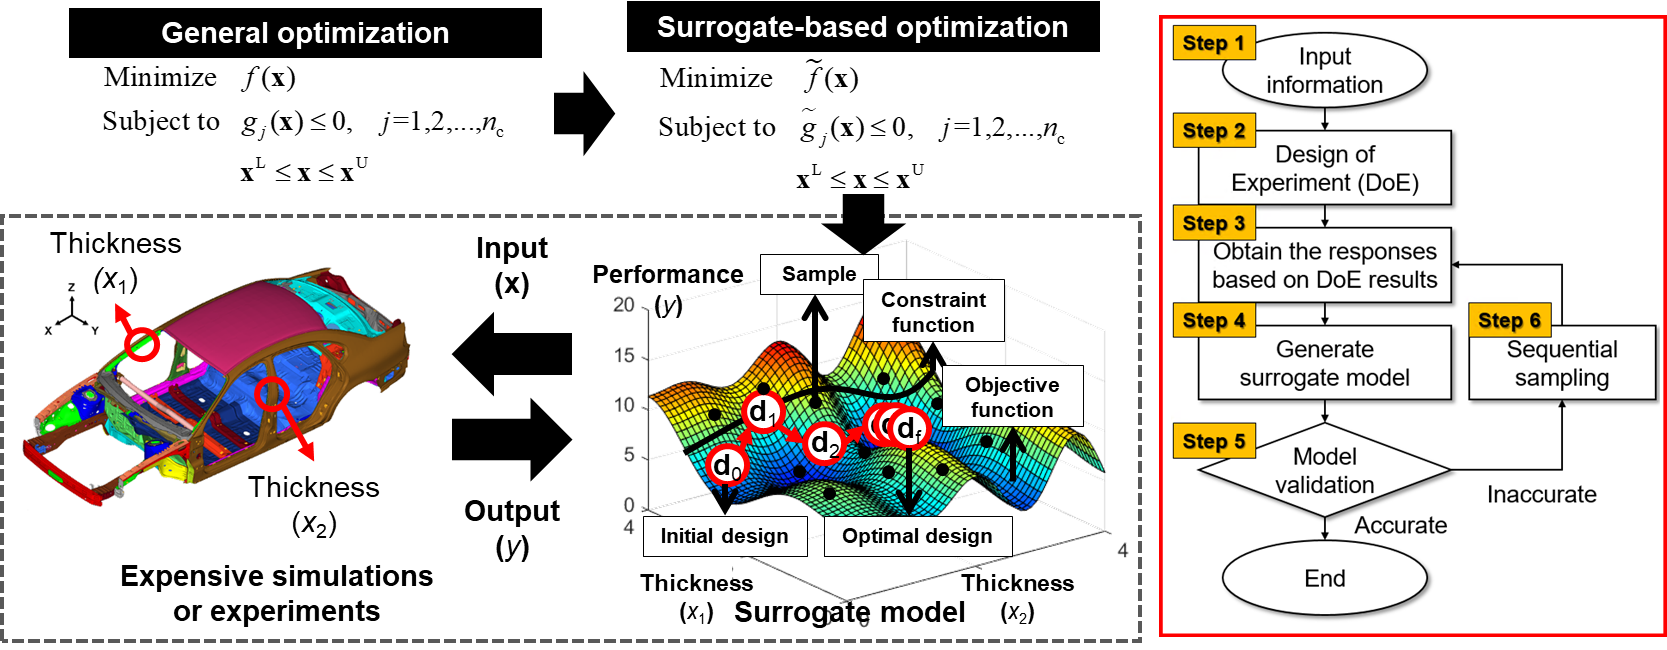

**1) 실험계획법 수행 (Step2)**

* 디자인 영역에서 다른 샘플과 겹치지 않으면서 (orthogonality) 고르게 (space-filling) 데이터를 확보

**2) 보유한 데이터 개수와 설계 변수 개수에 따른 대리 모델 선택 및 생성 (Step 4)**
* 인공신경망 기반 방법 vs 가우시안 프로세스 기반 방법 (e.g., Kriging, Co-Kriging)

**3) 기존의 샘플을 기반으로 유망한 영역에 샘플을 추가하여 대리 모델 업데이트 (Step 6)**
* Sequential sampling process (e.g., Bayesian optimization)

In [ ]:
# !pip install smt

## **▣ 실습: Two-dimensional Kriging example**

### ※ **예제 문제**
* 설계 변수 개수: 2개
* 설계 공간: -2<x<sub>1</sub><2, -2<x<sub>2</sub><2
* 예제 함수: Rosenbrock function
* 데이터 개수: 20개
* Kriging으로 대리모델링을 수행


In [2]:
from __future__ import print_function, division
import numpy as np
from scipy import linalg
from smt.utils import compute_rms_error

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

try:
    import matplotlib.pyplot as plt
    plot_status = True
except:
    plot_status = False

import scipy.interpolate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

## **Step 1: 인풋 정보 (or 전처리 과정)**

In [ ]:
ndim = 2 # 설계 변수 개수 (차원)
ndoe = 20 # 초기 데이터 개수

fun = Rosenbrock(ndim = ndim) # Black-box 모델 정의 (e.g., 함수, 시뮬레이션 모델)

## **Step2: 실험계획법 (DOE)**

In [ ]:
# 실험계획법 수행
# 디자인 영역에서 다른 샘플과 겹치지 않으면서 (orthogonality) 고르게 (space-filling) 데이터를 확보
# sampling = LHS(xlimits = fun.xlimits, random_state = 1) # 라틴 하이퍼 큐브 샘플링
# Optimize the design using the Enhanced Stochastic Evolutionary algorithm (ESE)
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1) # 라틴 하이퍼 큐브 샘플링
xt = sampling(ndoe)

print("Input data",xt) # 인풋 데이터

In [ ]:
# 시각화 (3D 문제 이상 부터는 불가능)
fig = plt.figure(figsize=(5, 5))
plt.scatter(xt[:,0],xt[:,1],marker = 'x',c='b',s=100,label='Training points')
plt.title('DOE result',fontsize=20)
plt.xlabel('$x_1$',fontsize=20)
plt.ylabel('$x_2$',fontsize=20)
plt.legend()
plt.show()

## **Step 3: 데이터 생성 (시뮬레이션 or 실험)**

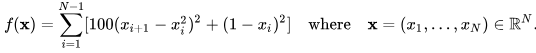

In [ ]:
# 아웃풋 데이터 생성 (실제 시뮬레이션 혹은 실험 수행)
yt = fun(xt) # 실제 아웃풋 데이터 생성

print("Output data",yt) # 아웃풋 데이터

## **Step 4: 대리 모델 구성 (Kriging)**

In [ ]:
# 대리모델링 (Main process)
initial_theta = [1e-2]*ndim # 초기 하이퍼파라미터 설정
sm = KRG(theta0 = initial_theta,print_prediction = False)
sm.set_training_values(xt,yt[:,0]) # 하이퍼파라미터 최적화
sm.train() # 하이퍼파라미터 최적화


# 하이퍼파라미터 변화
print("initial theta values",  initial_theta)
print("optimal theta values",  sm.optimal_theta)

In [ ]:
# 대리모델 save

#save model by joblib library
# import joblib
# joblib.dump(model, 'saved_model.pkl')

#save model by joblib library
import joblib
joblib.dump(sm, 'saved_model.pkl')


In [ ]:
# 대리모델 reload

import joblib
model = joblib.load('saved_model.pkl')

In [ ]:
# 모델 검증용 데이터 생성
ntest = 200
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
xtest = sampling(ntest)
ytest = fun(xtest)

In [ ]:
# Prediction of the validation points
y_pred = model.predict_values(xtest) # 최적화된 하이퍼파라미터가 적용된 크리깅 평균값 예측 모델
print('Kriging,  err: '+ str(compute_rms_error(sm,xtest,ytest)))

if plot_status:
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y_pred, 'r.', label='$\hat{y}$')

    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')

    plt.legend(loc='upper left')
    plt.title('Kriging model: validation of the prediction model')

if plot_status:
    plt.show()

## **Step 5: 모델 검증**

In [ ]:
# 모델 검증용 데이터 생성
ntest = 200
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
xtest = sampling(ntest)
ytest = fun(xtest)

In [ ]:
# Prediction of the validation points
y_pred = sm.predict_values(xtest) # 최적화된 하이퍼파라미터가 적용된 크리깅 평균값 예측 모델
print('Kriging,  err: '+ str(compute_rms_error(sm,xtest,ytest)))

if plot_status:
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y_pred, 'r.', label='$\hat{y}$')

    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')

    plt.legend(loc='upper left')
    plt.title('Kriging model: validation of the prediction model')

if plot_status:
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# The root mean squared error
print("Root mean squared error(RMSE): %.5f"
      % mean_squared_error(ytest, y_pred)**0.5)

In [ ]:
# Plot the surrogate model in 3D
x = np.linspace(-2, 2, 50)
resSM = []
varSM = []
for x0 in x:
    for x1 in x:
        resSM.append(sm.predict_values(np.array([[x0,x1]])))
        varSM.append(sm.predict_variances(np.array([[x0,x1]])))


In [ ]:
# 결과 시각화
resSM = np.array(resSM)
resSM = resSM.reshape((50,50)).T
varSM = np.array(varSM)
varSM = varSM.reshape((50,50)).T
X,Y = np.meshgrid(x,x)

fig = plt.figure(figsize=(15, 10))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.scatter(xt[:,0], xt[:,1], yt, zdir='z', marker='x', c='b', s=200, label='DOE')
surf = ax.plot_surface(X, Y, resSM, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
ax.scatter(xtest[:,0], xtest[:,1], ytest, zdir='z', marker='.', c='g', s=100, label='Test')
ax.scatter(xtest[:,0], xtest[:,1], y_pred, zdir='z', marker = 'x', c='r', s=100, label='Prediction')
plt.legend(fontsize=15,bbox_to_anchor=(1.1, 0.55))
plt.xlabel('$x_1$',fontsize=20)
plt.ylabel('$x_2$',fontsize=20)
plt.title('Rosenbrock function with the DOE points and predicted values',fontsize=20)

plt.show()

# Plot of the variance
fig = plt.figure(figsize=(15, 10))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, varSM, cmap=cm.viridis,
                       linewidth=0, antialiased=False, alpha=0.5)

plt.title('Rosenbrock surrogate model error',fontsize=25)
plt.xlabel('$x_1$',fontsize=20)
plt.ylabel('$x_2$',fontsize=20)
plt.show()

In [ ]:
# 예측값 및 불확실 정보 (테스트)
x_want = np.array([[1.2, 1.2]]) # 예측 포인트
y_want = sm.predict_values(x_want) # 예측값
s2_want = np.sqrt(sm.predict_variances(x_want)) # 불확실 정보
y_real = fun(x_want) # 실제값

print("예측값",y_want) # 예측값
print("불확실 정보",s2_want) # 불확실 정보
print("실제값",y_real) # 실제값

### ※ **응용 문제**
* 설계 변수 개수: 4개
* 설계 공간: -3<x<sub>1</sub><3, -4<x<sub>2</sub><4, -10<x<sub>3</sub><1, -3<x<sub>4</sub><5
* 예제 함수: Rosenbrock function
* 데이터 개수: 40개
* 초기 하이퍼파라미터 설정: [10<sup>-1</sup>, 10<sup>-1</sup>, 10<sup>-1</sup>, 10<sup>-1</sup>]
* Kriging으로 대리모델링을 수행


In [ ]:
ndim = 2 # 설계 변수 개수 (차원)
ndoe = 20 # 초기 데이터 개수

fun = Rosenbrock(ndim = ndim) # Black-box 모델 정의 (e.g., 함수, 시뮬레이션 모델)

# 실험계획법 수행
# 디자인 영역에서 다른 샘플과 겹치지 않으면서 (orthogonality) 고르게 (space-filling) 데이터를 확보
sampling = LHS(xlimits = fun.xlimits, criterion = 'ese', random_state = 1) # 라틴 하이퍼 큐브 샘플링
xt = sampling(ndoe)

# 아웃풋 데이터 생성 (실제 시뮬레이션 혹은 실험 수행)
yt = fun(xt)

# 대리모델링 (Main process)
initial_theta = [1e-2]*ndim # 초기 하이퍼파라미터 설정
sm = KRG(theta0 = initial_theta,print_prediction = False)
sm.set_training_values(xt,yt[:,0]) # 하이퍼파라미터 최적화
sm.train() # 하이퍼파라미터 최적화


# 하이퍼파라미터 변화
print("initial theta values",  initial_theta)
print("optimal theta values",  sm.optimal_theta)

# 예측값 및 불확실 정보 (테스트)
x_want = np.array([[1.2, 1.2]]) # 예측 포인트
y_want = sm.predict_values(x_want) # 예측값
s2_want = np.sqrt(sm.predict_variances(x_want)) # 불확실 정보
y_real = fun(x_want) # 실제값

In [ ]:
print("예측값",y_want) # 예측값
print("불확실 정보",s2_want) # 불확실 정보
print("실제값",y_real) # 실제값

### ※ **정답 코드**

In [ ]:
ndim = 4 # 설계 변수 개수 (차원)
ndoe = 40 # 초기 데이터 개수

fun = Rosenbrock(ndim=ndim) # Black-box 모델 정의 (e.g., 함수, 시뮬레이션 모델)

# 실험계획법 수행
# 디자인 영역에서 다른 샘플과 겹치지 않으면서 (orthogonality) 고르게 (space-filling) 데이터를 확보
design_xlimits = np.array([[-3,3],[-4,4],[-10,1],[-3,5]])
sampling = LHS(xlimits = design_xlimits, criterion = 'ese', random_state = 1) # 라틴 하이퍼 큐브 샘플링
xt = sampling(ndoe)

print("설계 영역",design_xlimits)
print("초기 실험 포인트",xt)

# 아웃풋 데이터 생성 (실제 시뮬레이션 혹은 실험 수행)
yt = fun(xt)

# 대리모델링 (Main process)
initial_theta = [1e-1]*ndim # 초기 하이퍼파라미터 설정
sm = KRG(theta0=initial_theta,print_prediction = False)
sm.set_training_values(xt,yt[:,0]) # 하이퍼파라미터 최적화
sm.train() # 하이퍼파라미터 최적화


# 하이퍼파라미터 변화
print("initial theta values",  initial_theta)
print("optimal theta values",  sm.optimal_theta)

# 예측값 및 불확실 정보 (테스트)
x_want = np.array([[1.2, 1.2, 1.2, 1.2]]) # 예측 포인트
y_want = sm.predict_values(x_want) # 예측값
s2_want = np.sqrt(sm.predict_variances(x_want)) # 불확실 정보
y_real = fun(x_want) # 실제값


In [ ]:
print("예측값",y_want) # 예측값
print("불확실 정보",s2_want) # 불확실 정보
print("실제값",y_real) # 실제값